In [1]:
#import all needed libraries
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline


# FBI Gun Data Analysis

## Table of Content:
<ul>
<li><a href = '#introduction'>Introduction</a></li>
<li><a href = '#data_wrangling'>Data Wrangling</a></li>
<li><a href = '#exploratory_data_analysis'>Exploratory Data Analysis</a></li>
<li><a href = '#conclusion'>Conclusion</a></li>
<ul>
    

<a id='introduction'></a>
## Introduction

This is a project based on the data from the FBI's National Instant Criminal Background Check System and the State level data from Census.gov.The orignal data can be found with files named 'gun_data.csv' and 'us.census data.csv' in the same repository. 



<a id = 'data_wrangling'></a>
## Data Wrangling

In [2]:
#show orginal data of 'us_census data.csv':
us_census_data = pd.read_csv('us_census data.csv')

In [3]:
#Drop the Fact Note column since it contains no useful information for analysis
us_census_data = us_census_data.drop(['Fact Note'], axis = 1)
#drop all the footnote and keep only the useful data with numbers values
us_census_data = us_census_data[:64] 
#Replace all Z,D and FN with 0 based on the footnote definition
us_census_data = us_census_data.replace({'Z':'0','D':'0','FN':'0'}) 
#Remove all ',', '%' and '$' in the dataframe
us_census_data.loc[:,'Alabama':'Wyoming'] = us_census_data.loc[:,'Alabama':'Wyoming'].replace({',':'','%':'',r'\$':''},regex = True)
#Cast the each column's value to float data type
us_census_data.loc[:,'Alabama':'Wyoming'] = us_census_data.loc[:,'Alabama':'Wyoming'].astype(float)


In [22]:
us_census_data.head(3)

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",4.8633e+06,741894,6.93107e+06,2.98825e+06,3.925e+07,5.54054e+06,3.57645e+06,952065,2.06124e+07,...,865454,6.65119e+06,2.78626e+07,3.05122e+06,624594,8.41181e+06,7.288e+06,1.8311e+06,5.77871e+06,585501
1,"Population estimates base, April 1, 2010, (V2...",4.78013e+06,710249,6.3923e+06,2.91602e+06,3.72545e+07,5.02932e+06,3.57411e+06,897936,1.88046e+07,...,814195,6.3463e+06,2.51461e+07,2.76389e+06,625741,8.00104e+06,6.72454e+06,1.85301e+06,5.68729e+06,563767
2,"Population, percent change - April 1, 2010 (es...",1.7,4.5,8.4,2.5,5.4,10.2,0.1,6,9.6,...,0.063,0.048,10.8,10.4,-0.2,5.1,8.4,-1.2,1.6,3.9


In [5]:
#read the original gun_data.csv 
fbi_gun_data = pd.read_csv('gun_data.csv') 

In [6]:
#fill NaN in the dataframe with 0
fbi_gun_data = fbi_gun_data.fillna(0) 
#Cast all values to float data type
fbi_gun_data.loc[:,'permit':'totals'] = fbi_gun_data.loc[:,'permit':'totals'].astype(float, inplace = True)
# convert the month column to datetime format
fbi_gun_data['month'] = pd.to_datetime(fbi_gun_data['month'])

In [23]:
fbi_gun_data.head(3)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals,year
0,2017-09-01,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317.0,0.0,15.0,...,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019.0,2017
1,2017-09-01,Alaska,209.0,2.0,2320.0,2930.0,219.0,160.0,0.0,5.0,...,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303.0,2017
2,2017-09-01,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631.0,0.0,13.0,...,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394.0,2017


<a id = 'exploratory_data_analysis'></a>
## Exploratory Data Analysis

#### 1.1 Population for different states (Census 2010)
In this section we will investigate population at different individual states at year 2010 when the most recent census was done

In [8]:
map_path = "./us_states/tl_2017_us_state.shp"
usa = gpd.read_file(map_path)
usa = usa.set_index('NAME').drop(['Guam','United States Virgin Islands','Commonwealth of the Northern Mariana Islands','American Samoa','District of Columbia','Puerto Rico'])


In [9]:
all_states_population = us_census_data.iloc[3]['Alabama':'Wyoming']
all_states_population = all_states_population.reset_index().rename(columns = {'index':'NAME',3:'Population'}).set_index('NAME')
usa = pd.concat([usa,all_states_population], axis = 1, sort = True)

Text(0.5, 1.0, 'Population in Each of the 48 Contiguous States. Data from 2010 Census, Area Map View')

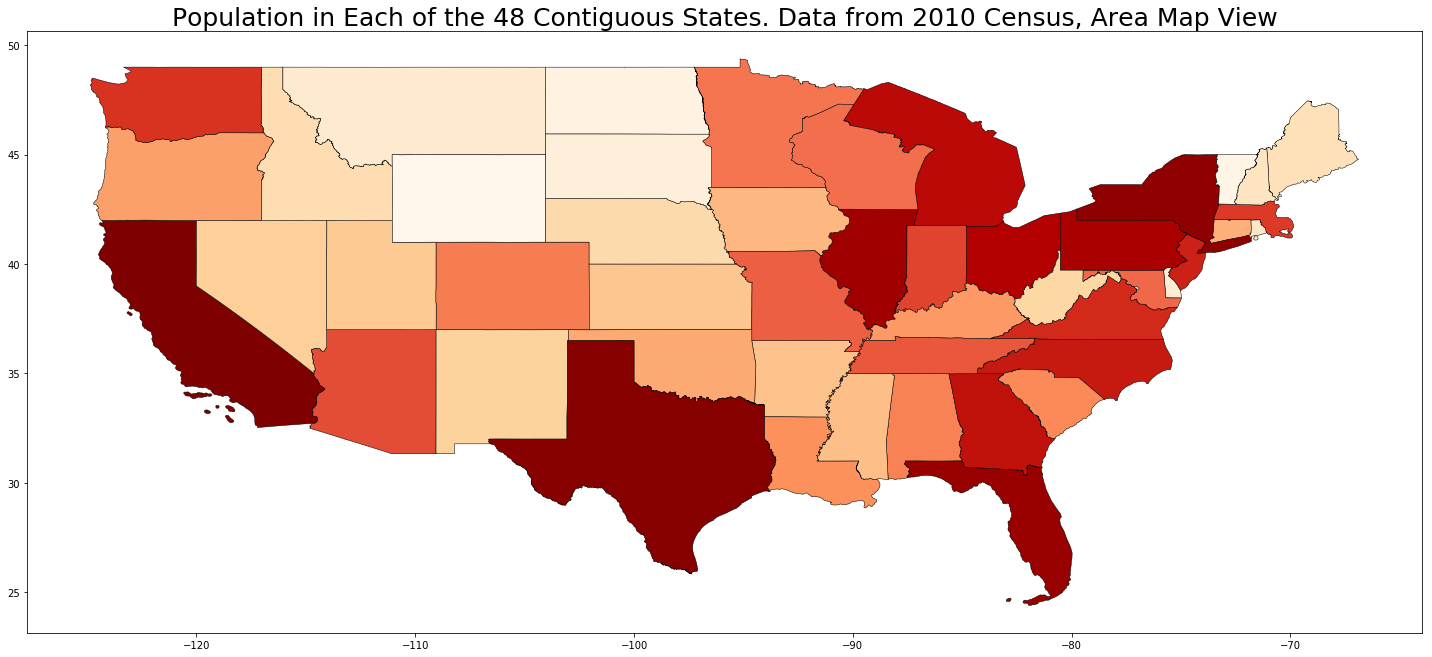

In [10]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Population', cmap = 'OrRd', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Population in Each of the 48 Contiguous States. Data from 2010 Census, Area Map View", fontsize = 25)


Text(0.5, 1.0, 'Population in Each of the 48 Contiguous States. Data from 2010 Census')

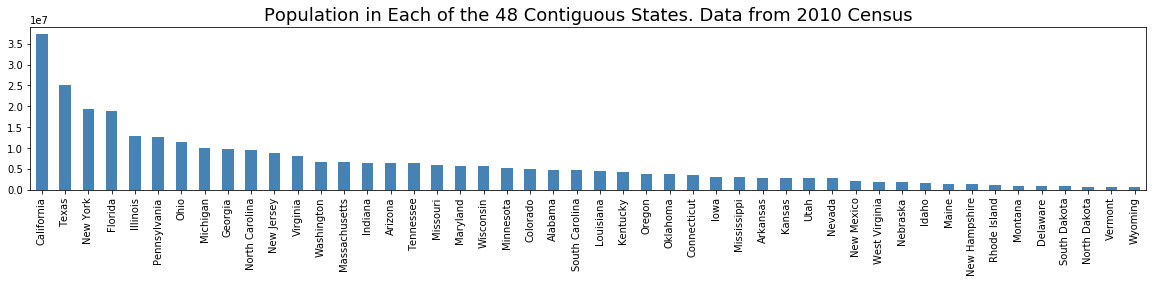

In [11]:
usa.drop(['Hawaii','Alaska'])['Population'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'steelblue')
plt.title("Population in Each of the 48 Contiguous States. Data from 2010 Census", fontsize = 18)

#### 1.2  Total permits issued at different states (Year 2016)
In this section we will investigate total gun registration in different states at year 2016

In [12]:
#create a new column stores the information of year for each row
fbi_gun_data['year'] = fbi_gun_data['month'].dt.year

#select rows with year 2016 and group the data by states and calculae the sum of totals for the year
# also, drop all the non-state data
gun_permit_y2016 = fbi_gun_data.loc[fbi_gun_data['year'] == 2016].groupby('state')['totals'].sum()\
.drop(index = ['District of Columbia','Guam','Mariana Islands','Puerto Rico','Virgin Islands'])

gun_permit_y2016 = gun_permit_y2016.reset_index().rename(columns = {'state':'NAME','totals':'Total Gun Permits'}).set_index('NAME')

usa = pd.concat([usa,gun_permit_y2016], axis = 1, sort = True)

Text(0.5, 1.0, 'Total Gun Permits Issued in 2016 - U.S. Area Map View')

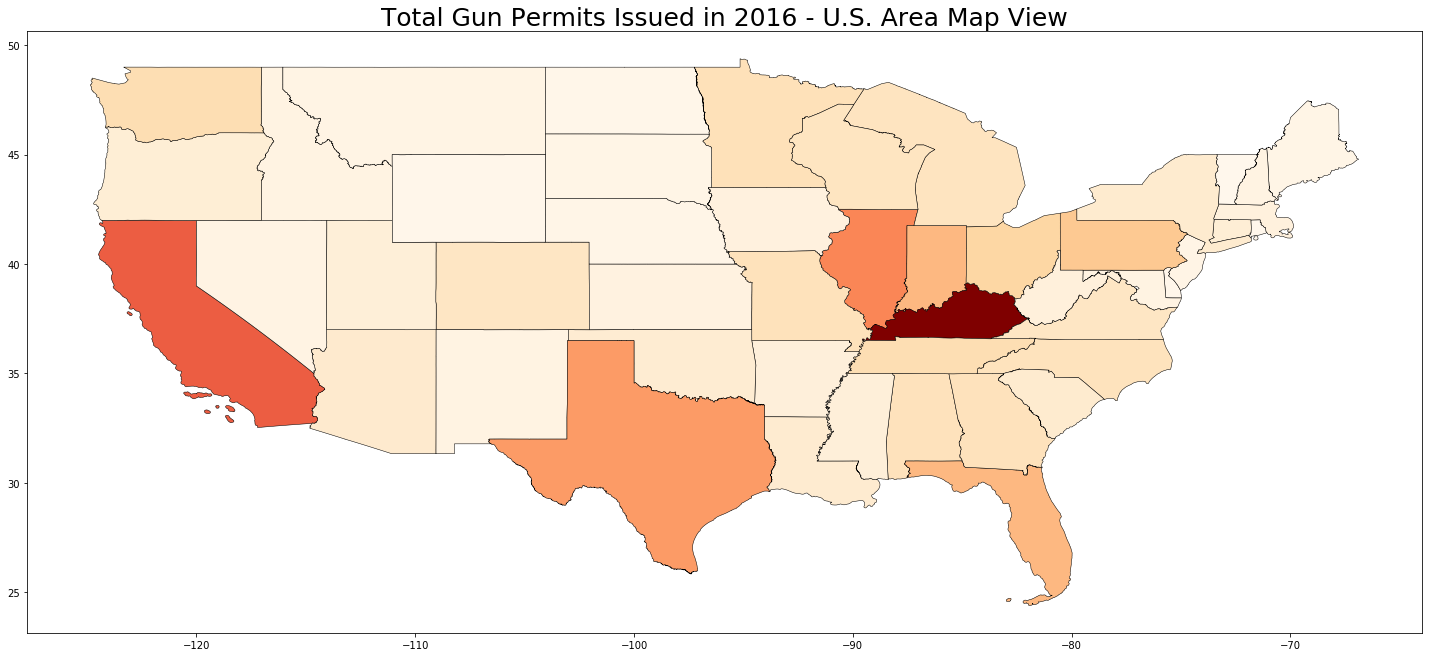

In [13]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Total Gun Permits', cmap = 'OrRd', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Total Gun Permits Issued in 2016 - U.S. Area Map View", fontsize = 25)

Text(0.5, 1.0, 'Total Gun Permits Issued in 2016')

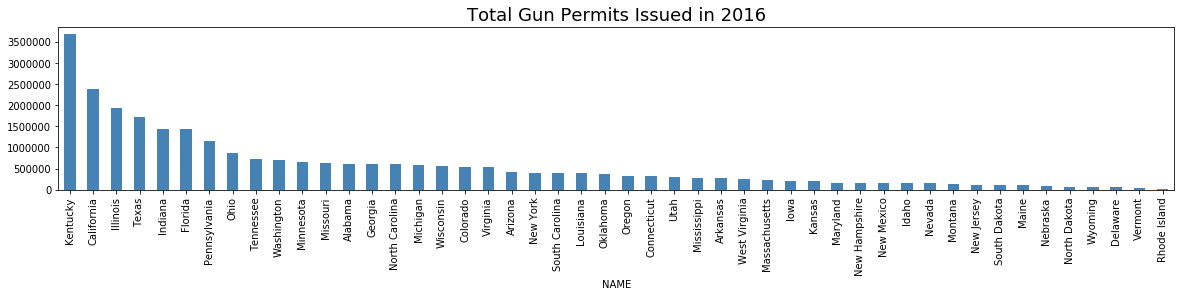

In [14]:
usa.drop(['Hawaii','Alaska'])['Total Gun Permits'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'steelblue')
plt.title("Total Gun Permits Issued in 2016", fontsize = 18)

Major findings: Kentucky has the highest number of gun registrations in all states in 2016.

#### 1.3 Gun permits per person at different states
In this section we will investigate the gun per capita for different states at yeat 2010

In [15]:
usa['Gun Permits per person'] = (usa['Total Gun Permits']/usa['Population'])*1000

Text(0.5, 1.0, 'Gun Permits Issued per 1000 population in 2016, U.S. Map View')

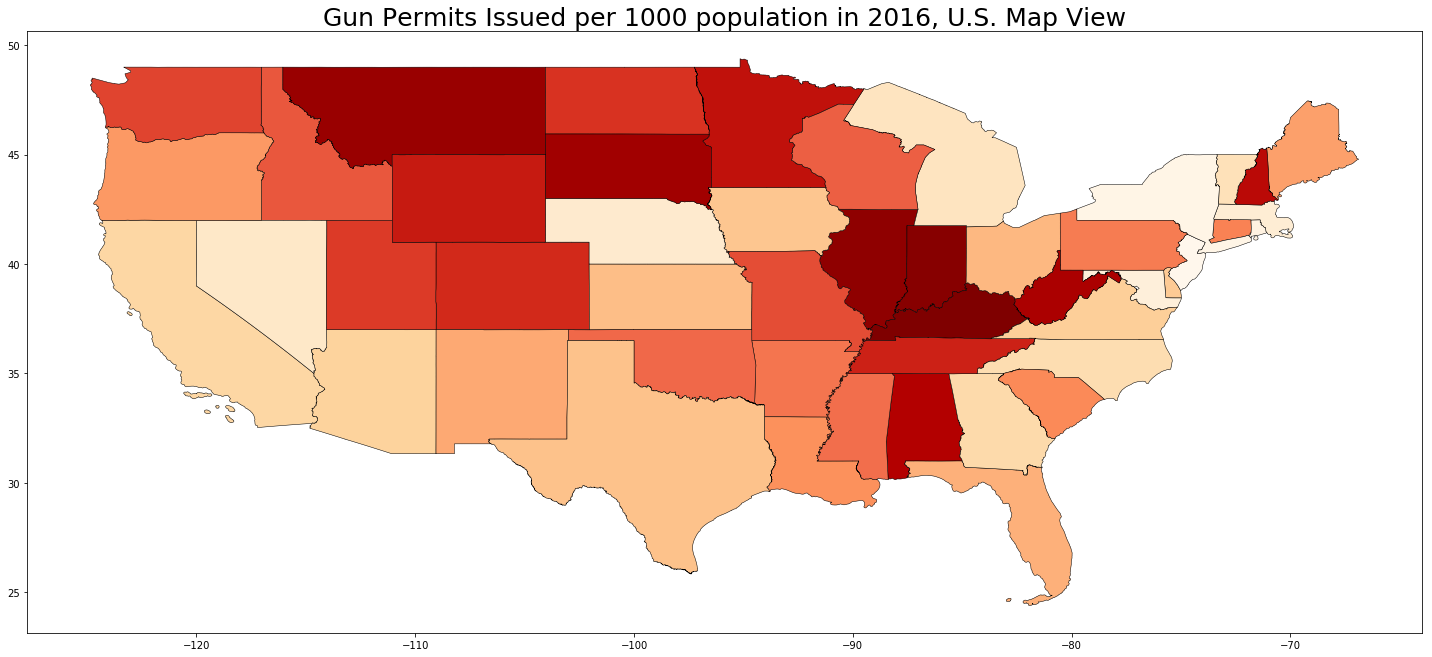

In [16]:
usa.drop(['Hawaii','Alaska']).plot(column = 'Gun Permits per person', cmap = 'OrRd', figsize = (25,25), linewidth = 0.5, edgecolor = 'k')
plt.title("Gun Permits Issued per 1000 population in 2016, U.S. Map View", fontsize = 25)

Text(0.5, 1.0, 'Gun Permits Issued per 1000 population in 2016')

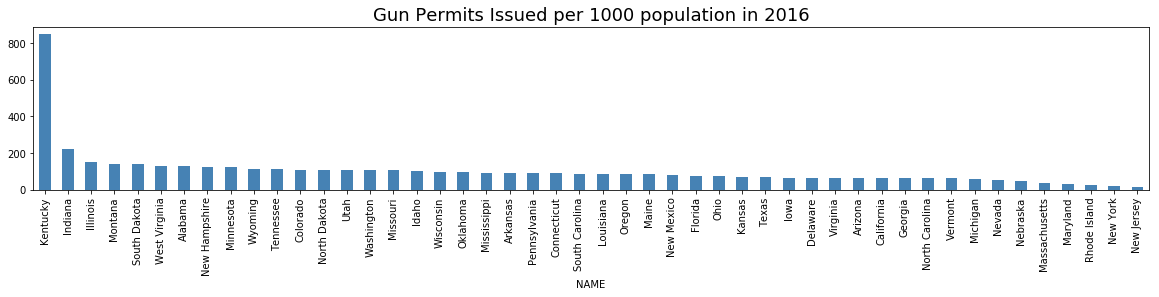

In [17]:
usa.drop(['Hawaii','Alaska'])['Gun Permits per person'].sort_values(ascending = False).plot(kind = 'bar', figsize = (20,3), color = 'steelblue')
plt.title("Gun Permits Issued per 1000 population in 2016", fontsize = 18)


Major findings: Kentucky has the highest per capita gun registration in all states in 2016

### 2. Change of total permits for United States and different states from 1999 - 2016

#### 2.1 Change of total permits for United States from 1999 - 2016
In this section we will look at the growth of total gun registration from 1999 to 2016 at national level

In [18]:
# Calculate the national total for different years pick only the data from 1999 to 2016\
# since they contain all months
permits_1999_to_2016 = fbi_gun_data.groupby(['year']).sum().iloc[1:-1]  
permits_1999_to_2016['total_million'] = (permits_1999_to_2016['totals']/1000000)

[Text(0, 0.5, 'Total Gun permits, millions'),
 Text(0.5, 1.0, 'Change of total permits for United States from 1999 - 2016')]

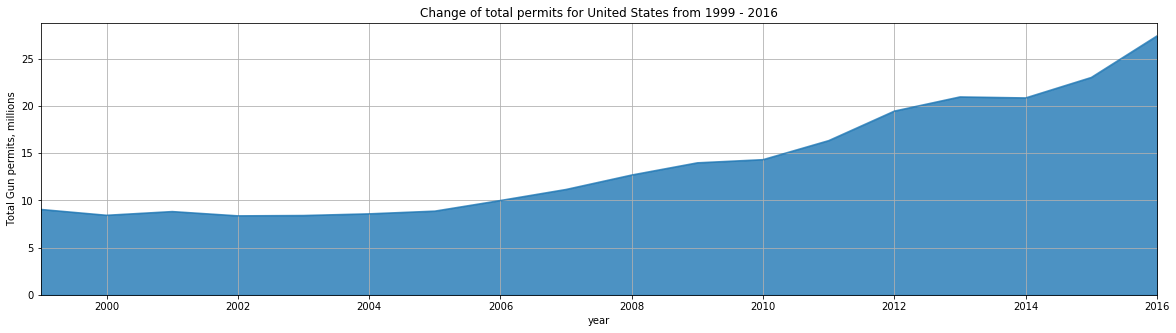

In [19]:
#plot the final result
permits_1999_to_2016['total_million'].plot(kind = 'area',figsize = (20,5),grid = True,alpha = 0.8).set(ylabel = 'Total Gun permits, millions', title = 'Change of total permits for United States from 1999 - 2016')


Major findings: The total gun registration is increasing steadily from 1999 to 2016.  

#### 2.2 Change of total permits for individual states from 1999 - 2016
In this section we will look at the growth of total gun registraion at state level from 1999 to 2016

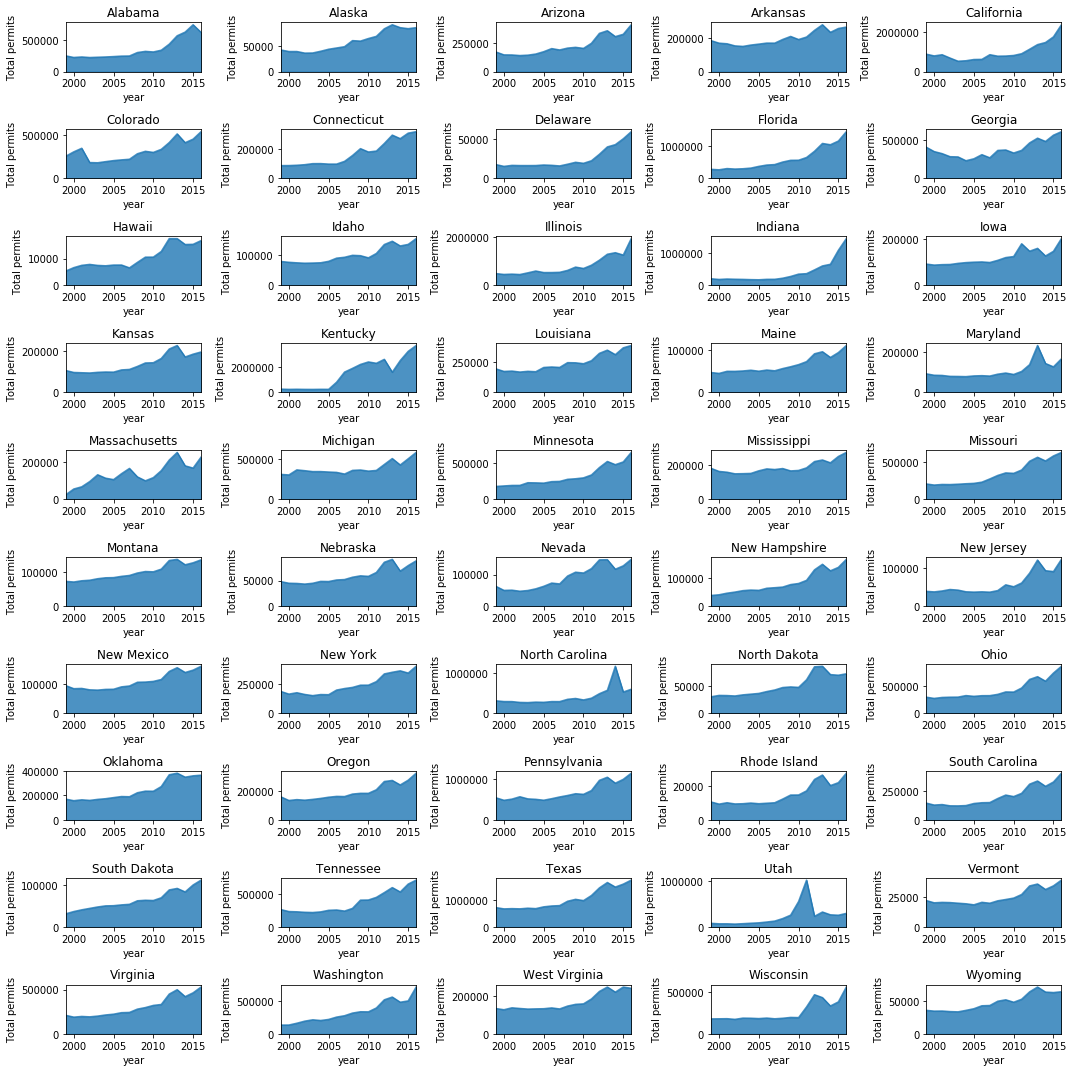

In [20]:
#create a figure with 50 empty subplot spots
fig, axes = plt.subplots(nrows=10, ncols=5) 
i = 0
k = 0

for state in us_census_data.drop(['Fact'], axis = 1).columns.tolist():
    if k <= 4:
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then,\
        #drop the data for 1988 and 2017 because they don't include the whole year
        state_permit_1999_2016 = fbi_gun_data.groupby(['state']).get_group(state).groupby(['year']).sum()[1:-1]
        
        #plot a subplot of a selected state 
        state_permit_1999_2016['totals'].plot(ax=axes[i,k],figsize = (15,15),title = state, kind = 'area',grid = False,alpha = 0.8).set(ylabel = 'Total permits')
        #move to next column positon on the same row
        k = k + 1 
    elif k > 4:
        # move the column to position 0
        k = 0
        # move the to next row
        i = i + 1
        # Group the modified df2 with selected state by 'year' calculate the yearly sum. Then,\
        #drop the data for 1988 and 2017 because they don't include the whole year
        state_permit_1999_2016 = fbi_gun_data.groupby(['state']).get_group(state).groupby(['year']).sum()[1:-1]
        #plot a subplot of a selected state 
        state_permit_1999_2016['totals'].plot(ax=axes[i,k],figsize = (20,20),title = state, kind = 'area',grid = False,alpha = 0.8).set(ylabel = 'Total permits')
        #move to next column positon on the same row
        k = k + 1
        
plt.tight_layout()